In [1]:
import time
import numpy as np
import pandas
import geopandas
from matplotlib import pyplot as plt
from shapely.ops import unary_union
from shapely.geometry import box, Point
from pprint import pprint
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

script_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/'
# Data from 2019 downloaded at: https://aec.gov.au/Electorates/gis/gis_datadownload.htm
data_dir = '/home/idies/workspace/Temporary/raddick/jordanraddick.com_temp/australia_districts/'
district_color_cycle = ['blue', 'red', 'green', 'orange', 'cyan', 'yellow', 'pink', 'gray', 'lime', 'navajowhite', 'cornflowerblue', 'darkseagreen', 'thistle', 'tomato', 'silver', 'blueviolet', 'olive', 'peru', 'dodgerblue']
district_color_cycle += district_color_cycle
district_color_cycle += district_color_cycle

the_crs_epsg = 3112
figsize_base = 24

map_buffer_ratio = 0.5

equal_area_crs = 2163  # An equal area projection: https://epsg.io/2163
g = 0

print('ok')


ok


# Get data

In [2]:
s = time.time()
print('reading data...')
agdf = geopandas.read_file(data_dir+'2021_ELB_region.shp')

print('removing outlying islands...')
mainland_geo_bounds = [112,-45,155,-8]
mainbox = box(mainland_geo_bounds[0], mainland_geo_bounds[1], mainland_geo_bounds[2], mainland_geo_bounds[3])
agdf = agdf.assign(orig_geometry = agdf.geometry)
agdf.loc[agdf[agdf['Elect_div'].isin(['Bean', 'Lingiari', 'Sydney'])].index, 'geometry'] = agdf[agdf['Elect_div'].isin(['Bean', 'Lingiari', 'Sydney'])].geometry.apply(lambda x: x.intersection(mainbox))

print('indexing by electoral division name...')
agdf = agdf.set_index('Elect_div')
agdf = agdf.sort_index()

print('adding wheel value for color scheme...')
agdf = agdf.assign(wheel = np.nan)
cnt = 0
for ix, thisrow in agdf.iterrows():
    agdf.loc[ix, 'wheel'] = np.mod(cnt,19)
    cnt += 1
agdf.loc[:, 'wheel'] = pandas.to_numeric(agdf['wheel'], downcast='integer', errors='coerce')
agdf.loc[['Sydney', 'Grayndler', 'Wentworth', 'North Sydney', 'Reid', 'Watson', 'Barton', 'Kingsford Smith', 'Banks', 'Blaxland', 'Bennelong', 'Parramatta', 'Hughes', 'Werriwa', 'Macarthur', 'Lindsay'], 'wheel'] = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
agdf.loc[['Melbourne', 'Macnamara', 'Kooyong', 'Higgins', 'Fraser', 'Isaacs'], 'wheel'] = [1,2,3,4,5,6]
agdf.loc[['Adelaide', 'Sturt', 'Hindmarsh', 'Makin', 'Mayo', 'Kingston', 'Boothby', 'Barker', 'Spence', 'Grey'], 'wheel'] = [1,2,3,4,5,6,7,8,9,10]
agdf.loc[['Brisbane', 'Griffith', 'Lilley', 'Ryan', 'Moreton', 'Dickson', 'Oxley', 'Rankin', 'Petrie', 'Longman', 'Forde', 'Fisher', 'Blair', 'Bowman', 'Fadden', 'Bonner', 'Fairfax', 'Wright', 'Wide Bay', 'Moncrieff', 'Richmond'], 'wheel'] = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,15,1,5]
agdf.loc[['Perth', 'Swan', 'Curtin', 'Tangney', 'Cowan', 'Burt', 'Moore', 'Fremantle', 'Pearce', 'Brand', 'Hasluck', 'Durack', 'Canning', "O'Connor"], 'wheel'] = [1,2,3,4,5,6,7,8,9,10,11,12,5,13]
agdf.loc[['Solomon', 'Kennedy', 'Maranoa', 'Gippsland'], 'wheel'] = [4,8,6,1]

agdf.loc[:, 'wheel'] = pandas.to_numeric(agdf['wheel'], downcast='integer', errors='coerce')

print('adding electoral division name abbreviations...')
agdf = agdf.assign(abbrev = agdf.index.map(lambda x: x[0:3].upper()))
agdf.loc['Barker', 'abbrev'] = 'BRK'
agdf.loc['Bennelong', 'abbrev'] = 'BNL'
agdf.loc['Blaxland', 'abbrev'] = 'BLX'
agdf.loc['Braddon', 'abbrev'] = 'BRD'
agdf.loc['Bradfield', 'abbrev'] = 'BDF'
agdf.loc['Calare', 'abbrev'] = 'CLR'
agdf.loc['Canning', 'abbrev'] = 'CNG'
agdf.loc['Chifley', 'abbrev'] = 'CHF'
agdf.loc['Cook', 'abbrev'] = 'COK'
agdf.loc['Cooper', 'abbrev'] = 'COP'
agdf.loc['Corio', 'abbrev'] = 'CRO'
agdf.loc['Cowan', 'abbrev'] = 'CWN'
agdf.loc['Forde', 'abbrev'] = 'FRD'
agdf.loc['Franklin', 'abbrev'] = 'FRK'
agdf.loc['Greenway', 'abbrev'] = 'GRN'
agdf.loc['Hindmarsh', 'abbrev'] = 'HDM'
agdf.loc['Kingsford Smith', 'abbrev'] = 'KSM'
agdf.loc['Lingiari', 'abbrev'] = 'LNG'
agdf.loc['Macarthur', 'abbrev'] = 'MCA'
agdf.loc['Mackellar', 'abbrev'] = 'MCK'
agdf.loc['Macquarie', 'abbrev'] = 'MCQ'
agdf.loc['Maribyrnong', 'abbrev'] = 'MRB'
agdf.loc['Moncrieff', 'abbrev'] = 'MCF'
agdf.loc['New England', 'abbrev'] = 'NNG'
agdf.loc['Parramatta', 'abbrev'] = 'PRM'


agdf = agdf.assign(area_sq_km = agdf.to_crs(epsg=equal_area_crs).geometry.apply(lambda x: x.area / (1000*1000)))
#min_area_for_full_label = agdf.loc['New England']['area_sq_km']
min_area_for_full_label = agdf.loc['Gippsland']['area_sq_km']


print('setting up label position display adjustments...')
agdf = agdf.assign(mainmap_label = True)
agdf = agdf.assign(inset_label = True)
agdf = agdf.assign(inner_inset_label = True)










agdf = agdf.assign(mainmap_use_abbrev = False)
agdf.loc[agdf['area_sq_km'] < min_area_for_full_label, 'mainmap_use_abbrev'] = True
#agdf.loc[['Grey', 'Mayo', 'Spence'], 'mainmap_use_abbrev'] = False

agdf = agdf.assign(inset_use_abbrev = True)
agdf = agdf.assign(inner_inset_use_abbrev = True)



agdf = agdf.assign(mainmap_label_adj_x = 0)
agdf = agdf.assign(mainmap_label_adj_y = 0)
agdf = agdf.assign(inset_label_adj_x = 0)
agdf = agdf.assign(inset_label_adj_y = 0)
agdf = agdf.assign(inner_inset_label_adj_x = 0)
agdf = agdf.assign(inner_inset_label_adj_y = 0)


##### MAIN MAP
agdf.loc[['Herbert', 'Solomon'], 'mainmap_use_abbrev'] = False

#agdf.loc['Solomon', ['mainmap_label_adj_x', 'mainmap_label_adj_y']] = [-0.025e6, 0.06e6]



#### ADELAIDE
agdf.loc[['Spence'], 'mainmap_label'] = False

agdf.loc[['Grey', 'Mayo'], 'mainmap_use_abbrev'] = False

agdf.loc['Mayo', ['mainmap_label_adj_x', 'mainmap_label_adj_y']] = [-0.025e6, -0.06e6]
agdf.loc['Barker', ['mainmap_label_adj_x', 'mainmap_label_adj_y']] = [0, -0.08e6]


agdf.loc[['Barker', 'Grey'], 'inset_label'] = False

agdf.loc[['Kingston', 'Mayo', 'Spence'], 'inset_use_abbrev'] = False

agdf.loc['Adelaide', ['inset_label_adj_x', 'inset_label_adj_y']] = [-2000,-2000]
agdf.loc['Boothby', ['inset_label_adj_x', 'inset_label_adj_y']] = [-4000,0]
agdf.loc['Hindmarsh', ['inset_label_adj_x', 'inset_label_adj_y']] = [-3000,5000]
agdf.loc['Spence', ['inset_label_adj_x', 'inset_label_adj_y']] = [-2700,-1800]
agdf.loc['Sturt', ['inset_label_adj_x', 'inset_label_adj_y']] = [2000,0]





#### PERTH
agdf.loc[['Brand', 'Burt', 'Cowan', 'Curtin', 'Fremantle', 'Hasluck', 'Moore', 'Perth', 'Swan', 'Tangney'], 'mainmap_label'] = False

agdf.loc[['Canning', 'Pearce'], 'mainmap_use_abbrev'] = False
agdf.loc[['Brand', 'Canning', 'Durack', 'Pearce'], 'inset_use_abbrev'] = False


agdf.loc['Canning', ['mainmap_label_adj_x', 'mainmap_label_adj_y']] = [-100000,-50000]
agdf.loc['Pearce', ['mainmap_label_adj_x', 'mainmap_label_adj_y']] = [-120000,20000]
agdf.loc['Hasluck', ['mainmap_label_adj_x', 'mainmap_label_adj_y']] = [120000,20000]


agdf.loc['Brand', ['inset_label_adj_x', 'inset_label_adj_y']] = [500,1500]
agdf.loc['Burt', ['inset_label_adj_x', 'inset_label_adj_y']] = [-1000,-3000]
agdf.loc['Canning', ['inset_label_adj_x', 'inset_label_adj_y']] = [-3000,-2500]
agdf.loc['Cowan', ['inset_label_adj_x', 'inset_label_adj_y']] = [500,2000]
agdf.loc['Curtin', ['inset_label_adj_x', 'inset_label_adj_y']] = [-5000,0]
agdf.loc['Durack', ['inset_label_adj_x', 'inset_label_adj_y']] = [-5000,2500]
agdf.loc['Fremantle', ['inset_label_adj_x', 'inset_label_adj_y']] = [-4000,-2000]
agdf.loc['Hasluck', ['inset_label_adj_x', 'inset_label_adj_y']] = [-4000,4000]
agdf.loc['Moore', ['inset_label_adj_x', 'inset_label_adj_y']] = [-3000,2000]
agdf.loc['Pearce', ['inset_label_adj_x', 'inset_label_adj_y']] = [-9000,7000]
agdf.loc['Perth', ['inset_label_adj_x', 'inset_label_adj_y']] = [-1000,-1500]
agdf.loc['Swan', ['inset_label_adj_x', 'inset_label_adj_y']] = [4000,1000]
agdf.loc['Tangney', ['inset_label_adj_x', 'inset_label_adj_y']] = [-3000,-1000]




###### BRISBANE
agdf.loc[['Bonner', 'Bowman', 'Brisbane', 'Dickson', 'Fairfax', 'Fisher', 'Griffith', 'Lilley', 'Longman', 'Petrie', 'Ryan'], 'mainmap_label'] = False
agdf.loc[['Blair', 'Bonner', 'Bowman', 'Dickson', 'Fadden', 'Fisher', 'Forde', 'Longman', 'McPherson', 'Moncrieff', 'Wright'], 'mainmap_label'] = False

agdf.loc[['Groom', 'Hinkler', 'Page', 'Richmond', 'Wide Bay'], 'mainmap_use_abbrev'] = False

agdf.loc['Blair', ['mainmap_label_adj_x', 'mainmap_label_adj_y']] = [-85000,40000]
agdf.loc['Groom', ['mainmap_label_adj_x', 'mainmap_label_adj_y']] = [-85000,-30000]
agdf.loc['Hinkler', ['mainmap_label_adj_x', 'mainmap_label_adj_y']] = [0,40000]
agdf.loc['Page', ['mainmap_label_adj_x', 'mainmap_label_adj_y']] = [40000,-30000]
agdf.loc['Richmond', ['mainmap_label_adj_x', 'mainmap_label_adj_y']] = [110000,-30000]
agdf.loc['Wide Bay', ['mainmap_label_adj_x', 'mainmap_label_adj_y']] = [60000,0]


agdf.loc[['Petrie', 'Richmond'], 'inset_label'] = False

agdf.loc[['Blair', 'Fairfax', 'Fisher', 'Longman', 'Wright'], 'inset_use_abbrev'] = False

agdf.loc['Blair', ['inset_label_adj_x', 'inset_label_adj_y']] = [-10000,65000]
agdf.loc['Bonner', ['inset_label_adj_x', 'inset_label_adj_y']] = [10000,12000]
agdf.loc['Bowman', ['inset_label_adj_x', 'inset_label_adj_y']] = [12000,-5000]
agdf.loc['Dickson', ['inset_label_adj_x', 'inset_label_adj_y']] = [-6000,2000]
agdf.loc['Fadden', ['inset_label_adj_x', 'inset_label_adj_y']] = [10000,-4000]
agdf.loc['Fairfax', ['inset_label_adj_x', 'inset_label_adj_y']] = [11000,1000]
agdf.loc['Fisher', ['inset_label_adj_x', 'inset_label_adj_y']] = [6500,-4500]
agdf.loc['Forde', ['inset_label_adj_x', 'inset_label_adj_y']] = [-6000,-6000]
agdf.loc['Longman', ['inset_label_adj_x', 'inset_label_adj_y']] = [10000,-7500]
agdf.loc['McPherson', ['inset_label_adj_x', 'inset_label_adj_y']] = [16000,4000]
agdf.loc['Moncrieff', ['inset_label_adj_x', 'inset_label_adj_y']] = [13000,-1000]
agdf.loc['Ryan', ['inset_label_adj_x', 'inset_label_adj_y']] = [-4000,500]



###### INNER BRISBANE
#agdf.loc[['Blair', 'Longman'], 'inner_inset_label'] = False

agdf.loc['Bowman', ['inner_inset_label_adj_x', 'inner_inset_label_adj_y']] = [6000,-3000]
agdf.loc['Brisbane', ['inner_inset_label_adj_x', 'inner_inset_label_adj_y']] = [-3000,2000]
agdf.loc['Dickson', ['inner_inset_label_adj_x', 'inner_inset_label_adj_y']] = [-9500,7500]
agdf.loc['Griffith', ['inner_inset_label_adj_x', 'inner_inset_label_adj_y']] = [5000,-2000]
agdf.loc['Lilley', ['inner_inset_label_adj_x', 'inner_inset_label_adj_y']] = [3000,1000]
agdf.loc['Forde', ['inner_inset_label_adj_x', 'inner_inset_label_adj_y']] = [2000,0]
agdf.loc['Moreton', ['inner_inset_label_adj_x', 'inner_inset_label_adj_y']] = [1500,-2000]
agdf.loc['Oxley', ['inner_inset_label_adj_x', 'inner_inset_label_adj_y']] = [-1000,-2000]
agdf.loc['Rankin', ['inner_inset_label_adj_x', 'inner_inset_label_adj_y']] = [2000,0]
agdf.loc['Ryan', ['inner_inset_label_adj_x', 'inner_inset_label_adj_y']] = [-8500,7000]



#### DARWIN
agdf.loc[['Solomon'], 'mainmap_label'] = False


agdf.loc[['Lingiari', 'Solomon'], 'inset_use_abbrev'] = False

agdf.loc['Lingiari', ['inset_label_adj_x', 'inset_label_adj_y']] = [4400, -7600]
agdf.loc['Solomon', ['inset_label_adj_x', 'inset_label_adj_y']] = [-4000, 6000]



# print('Backing up...')
# agdf_bk = agdf

e = time.time()
g += (e-s)
print('\n')
print('Read {0:,.0f} electoral divisions in {1:,.1f} seconds!'.format(len(agdf), e-s))
#agdf.head(1).T

reading data...
removing outlying islands...
indexing by electoral division name...
adding wheel value for color scheme...
adding electoral division name abbreviations...
setting up label position display adjustments...


Read 151 electoral divisions in 39.2 seconds!


In [3]:
s = time.time()

print('setting up insets...')
insets = {}

# insets['sydney'] = {}
# insets['sydney']['bounds'] = [150.5, -34.55, 151.45, -33.3]
# insets['sydney']['axes_position'] = [-0.005, 0.6325]
# insets['sydney']['axes_rel_size'] = .275
# insets['sydney']['title'] = 'Sydney'
# insets['sydney']['titlesize'] = 22
# insets['sydney']['linewidth'] = 1
# insets['sydney']['borderwidth'] = 3
# insets['sydney']['labelsize'] = 11

insets['melbourne'] = {}
insets['melbourne']['bounds'] = [144.25, -38.35, 145.4, -37.45]
insets['melbourne']['axes_position'] = [-0.025, 0.005]
insets['melbourne']['axes_rel_size'] = .3
insets['melbourne']['title'] = 'Melbourne'
insets['melbourne']['titlesize'] = 22
insets['melbourne']['linewidth'] = 1
insets['melbourne']['borderwidth'] = 3
insets['melbourne']['labelsize'] = 12

# insets['adelaide'] = {}
# insets['adelaide']['bounds'] = [138.4, -35.25, 138.85, -34.675]
# insets['adelaide']['axes_position'] = [0.45, 0.005]
# insets['adelaide']['axes_rel_size'] = .15
# insets['adelaide']['title'] = 'Adelaide'
# insets['adelaide']['titlesize'] = 20
# insets['adelaide']['linewidth'] = 1
# insets['adelaide']['borderwidth'] = 4
# insets['adelaide']['labelsize'] = 12

# insets['perth'] = {}
# insets['perth']['bounds'] = [115.65, -32.3, 116.1, -31.7]
# insets['perth']['axes_position'] = [0.85, 0] 
# insets['perth']['axes_rel_size'] = .15
# insets['perth']['title'] = 'Perth'
# insets['perth']['titlesize'] = 20
# insets['perth']['linewidth'] = 1
# insets['perth']['borderwidth'] = 4
# insets['perth']['labelsize'] = 12


# insets['brisbane'] = {}
# insets['brisbane']['bounds'] = [152.7, -28.25, 153.3, -26.7]
# insets['brisbane']['axes_position'] = [0.56, 0.71]
# insets['brisbane']['axes_rel_size'] = .125
# insets['brisbane']['title'] = 'Brisbane'
# insets['brisbane']['titlesize'] = 18
# insets['brisbane']['linewidth'] = 1
# insets['brisbane']['borderwidth'] = 4
# insets['brisbane']['labelsize'] = 12



# insets['darwin'] = {}
# insets['darwin']['bounds'] = [130.7, -12.65, 131.1, -12.25]
# insets['darwin']['axes_position'] = [0.31, 0.185]
# insets['darwin']['axes_rel_size'] = .1
# insets['darwin']['title'] = 'Darwin'
# insets['darwin']['titlesize'] = 18
# insets['darwin']['linewidth'] = 1
# insets['darwin']['borderwidth'] = 4
# insets['darwin']['labelsize'] = 12


inner_insets = {}

# inner_insets['innersyd'] = {}
# inner_insets['innersyd']['bounds'] = [150.925, -34.025, 151.3, -33.75]
# inner_insets['innersyd']['axes_position'] = [0.245, 0.844]
# inner_insets['innersyd']['axes_rel_size'] = .175
# inner_insets['innersyd']['title'] = 'Inner Sydney'
# inner_insets['innersyd']['titlesize'] = 18
# inner_insets['innersyd']['linewidth'] = 1
# inner_insets['innersyd']['borderwidth'] = 5
# inner_insets['innersyd']['labelsize'] = 11

inner_insets['innermel'] = {}
inner_insets['innermel']['bounds'] = [144.75 ,-37.98, 145.13, -37.7]
inner_insets['innermel']['axes_position'] = [0.2325, 0.005]
inner_insets['innermel']['axes_rel_size'] = .2
inner_insets['innermel']['title'] = 'Inner Melbourne'
inner_insets['innermel']['titlesize'] = 16
inner_insets['innermel']['linewidth'] = 1
inner_insets['innermel']['borderwidth'] = 3
inner_insets['innermel']['labelsize'] = 12
    

# inner_insets['innerbri'] = {}
# inner_insets['innerbri']['bounds'] = [152.85,-27.75,153.25,-27.2]
# inner_insets['innerbri']['axes_position'] = [0.85, 0.8175]
# inner_insets['innerbri']['axes_rel_size'] = .125
# inner_insets['innerbri']['title'] = 'Inner Brisbane'
# inner_insets['innerbri']['titlesize'] = 18
# inner_insets['innerbri']['linewidth'] = 1
# inner_insets['innerbri']['borderwidth'] = 5
# inner_insets['innerbri']['labelsize'] = 11




extra_border_thickness_for_inner_inset_on_inset = 1


for inner_inset_name, this_inner_inset in inner_insets.items():
    print('Processing {0:}...'.format(inner_inset_name))
    xspan = this_inner_inset['bounds'][2] - this_inner_inset['bounds'][0]
    yspan = this_inner_inset['bounds'][3] - this_inner_inset['bounds'][1]
    
    
    # This breaks crossing the meridian or poles
    inner_insets[inner_inset_name]['outer_bounds'] = [this_inner_inset['bounds'][0] - (xspan * map_buffer_ratio), this_inner_inset['bounds'][1] - (xspan * map_buffer_ratio), this_inner_inset['bounds'][2] + (xspan * map_buffer_ratio), this_inner_inset['bounds'][3] + (xspan * map_buffer_ratio)]
    inner_insets[inner_inset_name]['outer_bounds'] = [np.round(x,3) for x in inner_insets[inner_inset_name]['outer_bounds']]
    
    innerinsetbox = box(this_inner_inset['bounds'][0], this_inner_inset['bounds'][1], this_inner_inset['bounds'][2], this_inner_inset['bounds'][3])
    
    this_inner_inset['districts'] = agdf[agdf.geometry.apply(lambda x: x.within(innerinsetbox))].index
    print('\tDistricts:')
    print(this_inner_inset['districts'])
    agdf.loc[agdf.index.isin(this_inner_inset['districts']), 'mainmap_label'] = False
    
    this_inner_inset['partial_districts'] = agdf[(~(agdf.index.isin(this_inner_inset['districts']))) & (agdf.geometry.apply(lambda x: x.intersects(innerinsetbox)))].index
    print('\tPartial Districts:')
    print(this_inner_inset['partial_districts'])

    xouterspan = this_inner_inset['outer_bounds'][2] - this_inner_inset['outer_bounds'][0]
    youterspan = this_inner_inset['outer_bounds'][3] - this_inner_inset['outer_bounds'][1]
    
    aspect_ratio = xouterspan / youterspan
    
    inner_insets[inner_inset_name]['axes_size'] = [this_inner_inset['axes_rel_size'], (this_inner_inset['axes_rel_size'] / aspect_ratio)]
    
    print('\tTop of inner inset box: y = {0:}'.format(this_inner_inset['axes_position'][1] + this_inner_inset['axes_size'][1]))
    print('\tRight of inner inset box: y = {0:}'.format(this_inner_inset['axes_position'][0] + this_inner_inset['axes_size'][0]))




for inset_name, this_inset in insets.items():
    print('Processing {0:}...'.format(inset_name))
    xspan = this_inset['bounds'][2] - this_inset['bounds'][0]
    yspan = this_inset['bounds'][3] - this_inset['bounds'][1]
    
    # This breaks crossing the meridian or poles
    insets[inset_name]['outer_bounds'] = [this_inset['bounds'][0] - (xspan * map_buffer_ratio), this_inset['bounds'][1] - (xspan * map_buffer_ratio), this_inset['bounds'][2] + (xspan * map_buffer_ratio), this_inset['bounds'][3] + (xspan * map_buffer_ratio)]
    insets[inset_name]['outer_bounds'] = [np.round(x,3) for x in insets[inset_name]['outer_bounds']]
    
    insetbox = box(this_inset['bounds'][0], this_inset['bounds'][1], this_inset['bounds'][2], this_inset['bounds'][3])
    
    this_inset['districts'] = agdf[agdf.geometry.apply(lambda x: x.within(insetbox))].index
#     print('\tDistricts:')
#     print(this_inset['districts'])
    agdf.loc[agdf.index.isin(this_inset['districts']), 'mainmap_label'] = False
    
    this_inset['partial_districts'] = agdf[(~(agdf.index.isin(this_inset['districts']))) & (agdf.geometry.apply(lambda x: x.intersects(insetbox)))].index
#     print('\tPartial Districts:')
#     print(this_inset['partial_districts'])
    
    xouterspan = this_inset['outer_bounds'][2] - this_inset['outer_bounds'][0]
    youterspan = this_inset['outer_bounds'][3] - this_inset['outer_bounds'][1]
    
    aspect_ratio = xouterspan / youterspan

    insets[inset_name]['axes_size'] = [this_inset['axes_rel_size'], (this_inset['axes_rel_size'] / aspect_ratio)]
    
    print('\tTop of inset box: y = {0:}'.format(this_inset['axes_position'][1] + this_inset['axes_size'][1]))
    print('\tRight of inset box: y = {0:}'.format(this_inset['axes_position'][0] + this_inset['axes_size'][0]))
    

def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fe6' % (x * 1e-6)


e = time.time()
g += (e-s)
print('Done in {0:,.0f} minutes {1:,.1f} seconds!'.format(np.floor((e-s)/60), (e-s)%60))
#pprint(insets['melbourne'])


setting up insets...
Processing innermel...
	Districts:
Index(['Fraser', 'Higgins', 'Kooyong', 'Macnamara', 'Melbourne'], dtype='object', name='Elect_div')
	Partial Districts:
Index(['Chisholm', 'Cooper', 'Gellibrand', 'Goldstein', 'Gorton', 'Hotham',
       'Isaacs', 'Jagajaga', 'Lalor', 'Maribyrnong', 'Menzies', 'Wills'],
      dtype='object', name='Elect_div')
	Top of inner inset box: y = 0.17868421052631883
	Right of inner inset box: y = 0.4325
Processing melbourne...
	Top of inset box: y = 0.2723913043478277
	Right of inset box: y = 0.27499999999999997
Done in 0 minutes 0.1 seconds!


In [ ]:
s = time.time()

the_line_width = 1

label_districts = True
the_annotation_size = 14


# print('Finding map bounds...')
# mainland_australia_map_geo = unary_union(agdf.to_crs(the_crs_epsg).geometry.tolist())
# xlimits = [mainland_australia_map_geo.bounds[0], mainland_australia_map_geo.bounds[2]]
# ylimits = [mainland_australia_map_geo.bounds[1], mainland_australia_map_geo.bounds[3]]

# xspan = (xlimits[1]-xlimits[0])    
# yspan = (ylimits[1]-ylimits[0])    

# xlimits = [xlimits[0] - xspan*map_buffer_ratio, xlimits[1] + xspan*map_buffer_ratio]
# ylimits = [ylimits[0] - yspan*map_buffer_ratio, ylimits[1] + yspan*map_buffer_ratio]

# aspect_ratio = (xlimits[1]-xlimits[0]) / (ylimits[1]-ylimits[0])

# print(xlimits)
# print(ylimits)
# print(aspect_ratio)


xlimits = [-2483777.4099375363, 2324760.683671837]
ylimits = [-5359317.178101439, -724627.4644418766]
aspect_ratio = 1.0375102521831048


#show_districts = []
show_districts = ['Durack', "O'Connor", 'Leichhardt', 'Franklin', 'Lyons', 'Wannon', 'Flynn', 'New England']

## Sydney
# show_districts += ['Banks', 'Barton', 'Bennelong', 'Berowra', 'Blaxland', 'Bradfield', 'Chifley', 'Cook', 'Cunningham', 'Fowler', 'Grayndler', 'Greenway', 'Hughes', 'Kingsford Smith', 'Lindsay', 'Macarthur', 'Mackellar', 'McMahon', 'Mitchell', 'North Sydney', 'Parramatta', 'Reid', 'Sydney', 'Warringah', 'Watson', 'Wentworth', 'Werriwa']
# show_districts += ['Calare', 'Dobell', 'Hume', 'Macquarie', 'Robertson', 'Whitlam']


## Melbourne
show_districts += ['Aston', 'Bruce', 'Calwell', 'Chisholm', 'Cooper', 'Deakin', 'Dunkley', 'Fraser', 'Gellibrand', 'Goldstein', 'Gorton', 'Higgins', 'Hotham', 'Isaacs', 'Jagajaga', 'Kooyong', 'Lalor', 'Macnamara', 'Maribyrnong', 'Melbourne', 'Menzies', 'Scullin', 'Wills']  # Melbourne
show_districts += ['Ballarat', 'Bendigo', 'Casey', 'Corangamite', 'Corio', 'Flinders', 'Hawke', 'Holt', 'Indi', 'La Trobe', 'McEwen', 'Nicholls']  # Melbourne (partial)

# ## Adelaide
# show_districts += ['Adelaide', 'Boothby', 'Hindmarsh', 'Kingston', 'Makin', 'Sturt']
# show_districts += ['Barker', 'Grey', 'Mayo', 'Spence']

# # ## Perth
# show_districts += ['Burt', 'Cowan', 'Curtin', 'Moore', 'Perth', 'Swan', 'Tangney']
# show_districts += ['Brand', 'Canning', 'Fremantle', 'Hasluck', 'Pearce']

# ## Brisbane
# show_districts += ['Brisbane', 'Griffith', 'Lilley', 'Moreton', 'Oxley', 'Petrie', 'Rankin']
# show_districts += ['Blair', 'Bonner', 'Bowman', 'Dickson', 'Fadden', 'Fairfax', 'Fisher','Forde', 'Longman', 'McPherson', 'Moncrieff', 'Richmond', 'Ryan','Wright']
# show_districts += ['Groom', 'Richmond', 'Page', 'Fairfax']

# ## Darwin
#show_districts += ['Solomon', 'Lingiari']

    
show_districts = sorted(show_districts)
# main_map_partial_districts = {}

if (len(show_districts) > 0):
    show_districts_ix = pandas.Index(show_districts)
#     for x in show_districts:
#         if (x not in main_map_districts):
#             show_districts_ix = show_districts_ix.drop(x)
else:
    show_districts_ix = agdf.index


fig, ax = plt.subplots(1,1,figsize=(figsize_base, figsize_base/aspect_ratio))

print('Plotting main map...')
cnt = 0
for ix, thisrow in agdf[agdf.index.isin(show_districts_ix)].iterrows():
    if (np.mod(cnt,10) == 0):
        print('\tPlotting District {0:,.0f} of {1:,.0f}...'.format(cnt, len(show_districts_ix)))
    agdf[agdf.index == ix].to_crs(epsg=the_crs_epsg).plot(ax=ax, color=district_color_cycle[thisrow['wheel']], edgecolor='black', lw=the_line_width)
    if (label_districts):
        if (thisrow['mainmap_label']):
            if (agdf.loc[ix]['mainmap_use_abbrev'] == False):
                annotator = ix.replace(' ','\n')
            else:
                annotator = thisrow['abbrev']
            labelpoint = agdf[agdf.index == ix].to_crs(epsg=the_crs_epsg).geometry.apply(lambda x: x.centroid).values[0].coords[0]
#            print(ix)
            labelpoint = (labelpoint[0]+thisrow['mainmap_label_adj_x'], labelpoint[1]+thisrow['mainmap_label_adj_y'])
#            print(labelpoint)
#            print('\n')
            ax.annotate(annotator, labelpoint, ha='center', va='center', 
                    bbox=dict(boxstyle='square,pad=0.3', fc='white', ec='black'),
                    fontsize=the_annotation_size)
    cnt += 1
    
ax.set_xlim(xlimits)
ax.set_ylim(ylimits)

# nticks = 10
# ax.set_xticks(np.arange(xlimits[0], xlimits[1], (xlimits[1]-xlimits[0])/nticks))
# #ax.set_xticks(np.arange(-2.5e6, 2.5e6, 5e6/nticks))
# ax.xaxis.set_major_formatter(ticker.FuncFormatter(millions))

# ax.set_yticks(np.arange(ylimits[0], ylimits[1], (ylimits[1]-ylimits[0])/nticks))
# ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions))

# ax.xaxis.set_tick_params(labelbottom=True, labeltop=True, labelsize=20, length=10, width=4, left=True, right=True)
# ax.yaxis.set_tick_params(labelleft=True, labelright=True, labelsize=20, length=10, width=4, top=True, bottom=True)

ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])

print('\n')    
print('Plotting first-level insets...')
for inset_name, this_inset in insets.items():
    print('\n')    
    print('\tplotting {0:}...'.format(inset_name))
    
    this_inset['axes'] = ax.inset_axes([this_inset['axes_position'][0], this_inset['axes_position'][1], this_inset['axes_size'][0], this_inset['axes_size'][1]])
    this_inset['axes'].set_aspect('equal')
    cnt = 0
    print('\t\tPlotting districts within...')
    for ix, thisrow in agdf[agdf.index.isin(this_inset['districts'])].iterrows():
        if (np.mod(cnt, 5) == 0):
            print('\t\t\tPlotting electoral division {0:,.0f} of {1:,.0f}...'.format(cnt, len(this_inset['districts'])))
        agdf[agdf.index == ix].to_crs(epsg=the_crs_epsg).plot(ax=this_inset['axes'], color=district_color_cycle[thisrow['wheel']], edgecolor='black', lw=the_line_width)
        cnt += 1
    
    cnt = 0
    print('\t\tPlotting districts partially within...')
    for ix, thisrow in agdf[agdf.index.isin(this_inset['partial_districts'])].iterrows():
        if (np.mod(cnt, 5) == 0):
            print('\t\t\tPlotting electoral division {0:,.0f} of {1:,.0f}...'.format(cnt, len(this_inset['partial_districts'])))
        agdf[agdf.index == ix].to_crs(epsg=the_crs_epsg).plot(ax=this_inset['axes'], color=district_color_cycle[thisrow['wheel']], edgecolor='black', lw=the_line_width)
        cnt += 1
    if (inner_inset_name == 'melbourne'):
        agdf[agdf.index == 'Bendigo'].to_crs(epsg=the_crs_epsg).plot(ax=this_inset['axes'], color=district_color_cycle[agdf.loc['Bendigo']['wheel']], edgecolor='black', lw=the_line_width)
        agdf[agdf.index == 'Nicholls'].to_crs(epsg=the_crs_epsg).plot(ax=this_inset['axes'], color=district_color_cycle[agdf.loc['Nicholls']['wheel']], edgecolor='black', lw=the_line_width)
        #agdf[agdf.index == 'Bendigo'].to_crs(epsg=the_crs_epsg).plot(ax=this_inner_inset['axes'], color=district_color_cycle[agdf.loc['Bendigo']['wheel']], edgecolor='black', lw=the_line_width)


    if (label_districts):
        print('\t\tlabeling districts fully within {0:}...'.format(inset_name))
        districts_to_label = agdf[(agdf.index.isin(this_inset['districts'])) & (agdf['inset_label'])].index.tolist()
        if (inset_name == 'melbourne'):
            districts_to_label = [x for x in districts_to_label if x not in inner_insets['innermel']['districts']]
        if (inset_name == 'sydney'):
            districts_to_label = [x for x in districts_to_label if x not in inner_insets['innersyd']['districts']]
        if (inset_name == 'brisbane'):
            districts_to_label = [x for x in districts_to_label if x not in inner_insets['innerbri']['districts']]
        axes_to_label_on = this_inset['axes']
        for ix, thisrow in agdf[agdf.index.isin(districts_to_label)].iterrows():
            if (thisrow['inset_use_abbrev']):
                annotator = thisrow['abbrev']
            else:
                annotator = ix
            labelpoint = agdf[agdf.index == ix].to_crs(epsg=the_crs_epsg).geometry.apply(lambda x: x.centroid.coords[0]).values[0]
            labelpoint = (labelpoint[0]+thisrow['inset_label_adj_x'], labelpoint[1]+thisrow['inset_label_adj_y'])
            axes_to_label_on.annotate(annotator, labelpoint, ha='center', va='center', 
                                      bbox=dict(boxstyle='square,pad=0.3', fc='white', ec='black'), 
                                      fontsize=this_inset['labelsize']
                                     )
        print('\t\tlabeling districts partially within {0:}...'.format(inset_name))
        partial_districts_to_label = agdf[(agdf.index.isin(this_inset['partial_districts'])) & (agdf['inset_label'])].index.tolist()
        for ix, thisrow in agdf[agdf.index.isin(partial_districts_to_label)].iterrows():
            if (thisrow['inset_use_abbrev']):
                annotator = thisrow['abbrev']
            else:
                annotator = ix
            labelpoint = geopandas.overlay(
                agdf[agdf.index == ix].to_crs(epsg=the_crs_epsg), 
                geopandas.GeoDataFrame(data=[[box(this_inset['outer_bounds'][0], this_inset['outer_bounds'][1], this_inset['outer_bounds'][2], this_inset['outer_bounds'][3])]], columns=['geometry'], crs=agdf.crs, geometry='geometry').to_crs(epsg=the_crs_epsg),
                how='intersection').geometry.apply(lambda x: x.centroid.coords[0]).values[0]
            labelpoint = (labelpoint[0]+thisrow['inset_label_adj_x'], labelpoint[1]+thisrow['inset_label_adj_y'])
            axes_to_label_on.annotate(annotator, labelpoint, ha='center', va='center', 
                                      bbox=dict(boxstyle='square,pad=0.3', fc='white', ec='black'), 
                                      fontsize=this_inset['labelsize']
                                     )
        
    outer_window_box = geopandas.GeoDataFrame(data=[[box(this_inset['outer_bounds'][0], this_inset['outer_bounds'][1], this_inset['outer_bounds'][2], this_inset['outer_bounds'][3])]], columns=['geometry'], crs=agdf.crs, geometry='geometry').to_crs(epsg=the_crs_epsg).geometry
    this_inset['axes'].set_xlim(outer_window_box.bounds['minx'].values[0], outer_window_box.bounds['maxx'].values[0])
    this_inset['axes'].set_ylim(outer_window_box.bounds['miny'].values[0], outer_window_box.bounds['maxy'].values[0])
    
    this_inset['axes'].get_xaxis().set_ticks([])
    this_inset['axes'].get_yaxis().set_ticks([])
    
    this_inset['axes'].set_title(this_inset['title'], size=this_inset['titlesize'])

    geopandas.GeoDataFrame(data=[[box(this_inset['bounds'][0],this_inset['bounds'][1],this_inset['bounds'][2], this_inset['bounds'][3])]], columns=['geometry'], crs=agdf.crs, geometry='geometry').to_crs(epsg=the_crs_epsg).plot(ax=this_inset['axes'], color='none', edgecolor='black', lw=this_inset['borderwidth'], zorder=1.5)
    geopandas.GeoDataFrame(data=[[box(this_inset['bounds'][0],this_inset['bounds'][1],this_inset['bounds'][2], this_inset['bounds'][3])]], columns=['geometry'], crs=agdf.crs, geometry='geometry').to_crs(epsg=the_crs_epsg).plot(ax=ax, color='none', edgecolor='black', lw=this_inset['borderwidth'], zorder=1.5)

        
print('\n')        
print('Plotting second-level insets...')

for inner_inset_name, this_inner_inset in inner_insets.items():
    print('\n')    
    print('\tplotting {0:}...'.format(inner_inset_name))
    
    this_inner_inset['axes'] = ax.inset_axes([this_inner_inset['axes_position'][0], this_inner_inset['axes_position'][1], this_inner_inset['axes_size'][0], this_inner_inset['axes_size'][1]])
    this_inner_inset['axes'].set_aspect('equal')
    cnt = 0
    print('\t\tPlotting districts within...')
    for ix, thisrow in agdf[agdf.index.isin(this_inner_inset['districts'])].iterrows():
        if (np.mod(cnt, 5) == 0):
            print('\t\t\tPlotting electoral division {0:,.0f} of {1:,.0f}...'.format(cnt, len(this_inner_inset['districts'])))
        agdf[agdf.index == ix].to_crs(epsg=the_crs_epsg).plot(ax=this_inner_inset['axes'], color=district_color_cycle[thisrow['wheel']], edgecolor='black', lw=the_line_width)
        cnt += 1
    
    cnt = 0
    print('\t\tPlotting districts partially within...')
    for ix, thisrow in agdf[agdf.index.isin(this_inner_inset['partial_districts'])].iterrows():
        if (np.mod(cnt, 5) == 0):
            print('\t\t\tPlotting electoral division {0:,.0f} of {1:,.0f}...'.format(cnt, len(this_inner_inset['partial_districts'])))
        agdf[agdf.index == ix].to_crs(epsg=the_crs_epsg).plot(ax=this_inner_inset['axes'], color=district_color_cycle[thisrow['wheel']], edgecolor='black', lw=the_line_width)
        cnt += 1
    
    #### Fix for districts in innermel that don't quite overlap
    if (inner_inset_name == 'innermel'):
        agdf[agdf.index == 'Hawke'].to_crs(epsg=the_crs_epsg).plot(ax=this_inner_inset['axes'], color=district_color_cycle[agdf.loc['Hawke']['wheel']], edgecolor='black', lw=the_line_width)
        agdf[agdf.index == 'Calwell'].to_crs(epsg=the_crs_epsg).plot(ax=this_inner_inset['axes'], color=district_color_cycle[agdf.loc['Calwell']['wheel']], edgecolor='black', lw=the_line_width)
        agdf[agdf.index == 'Scullin'].to_crs(epsg=the_crs_epsg).plot(ax=this_inner_inset['axes'], color=district_color_cycle[agdf.loc['Scullin']['wheel']], edgecolor='black', lw=the_line_width)
        agdf[agdf.index == 'Indi'].to_crs(epsg=the_crs_epsg).plot(ax=this_inner_inset['axes'], color=district_color_cycle[agdf.loc['Indi']['wheel']], edgecolor='black', lw=the_line_width)

    if (label_districts):
        print('\t\tlabeling districts fully within {0:}...'.format(inner_inset_name))
        districts_to_label = agdf[(agdf.index.isin(this_inner_inset['districts'])) & (agdf['inner_inset_label'])].index.tolist()
        axes_to_label_on = this_inner_inset['axes']
        for ix, thisrow in agdf[agdf.index.isin(districts_to_label)].iterrows():
            if (thisrow['inner_inset_use_abbrev']):
                annotator = thisrow['abbrev']
            else:
                annotator = ix
            labelpoint = agdf[agdf.index == ix].to_crs(epsg=the_crs_epsg).geometry.apply(lambda x: x.centroid.coords[0]).values[0]
            labelpoint = (labelpoint[0]+thisrow['inner_inset_label_adj_x'], labelpoint[1]+thisrow['inner_inset_label_adj_y'])
            axes_to_label_on.annotate(annotator, labelpoint, ha='center', va='center', 
                                      bbox=dict(boxstyle='square,pad=0.3', fc='white', ec='black'), 
                                      fontsize=this_inset['labelsize']
                                     )
        print('\t\tlabeling districts partially within {0:}...'.format(inner_inset_name))
        partial_districts_to_label = agdf[(agdf.index.isin(this_inner_inset['partial_districts'])) & (agdf['inner_inset_label'])].index.tolist()
        for ix, thisrow in agdf[agdf.index.isin(partial_districts_to_label)].iterrows():
            if (thisrow['inner_inset_use_abbrev']):
                annotator = thisrow['abbrev']
            else:
                annotator = ix
            labelpoint = geopandas.overlay(
                agdf[agdf.index == ix].to_crs(epsg=the_crs_epsg), 
                geopandas.GeoDataFrame(data=[[box(this_inner_inset['outer_bounds'][0], this_inner_inset['outer_bounds'][1], this_inner_inset['outer_bounds'][2], this_inner_inset['outer_bounds'][3])]], columns=['geometry'], crs=agdf.crs, geometry='geometry').to_crs(epsg=the_crs_epsg),
                how='intersection').geometry.apply(lambda x: x.centroid.coords[0]).values[0]
            labelpoint = (labelpoint[0]+thisrow['inner_inset_label_adj_x'], labelpoint[1]+thisrow['inner_inset_label_adj_y'])
            axes_to_label_on.annotate(annotator, labelpoint, ha='center', va='center', 
                                      bbox=dict(boxstyle='square,pad=0.3', fc='white', ec='black'), 
                                      fontsize=this_inset['labelsize']
                                     )
        
    outer_window_box = geopandas.GeoDataFrame(data=[[box(this_inner_inset['outer_bounds'][0], this_inner_inset['outer_bounds'][1], this_inner_inset['outer_bounds'][2], this_inner_inset['outer_bounds'][3])]], columns=['geometry'], crs=agdf.crs, geometry='geometry').to_crs(epsg=the_crs_epsg).geometry
    this_inner_inset['axes'].set_xlim(outer_window_box.bounds['minx'].values[0], outer_window_box.bounds['maxx'].values[0])
    this_inner_inset['axes'].set_ylim(outer_window_box.bounds['miny'].values[0], outer_window_box.bounds['maxy'].values[0])
    
    this_inner_inset['axes'].get_xaxis().set_ticks([])
    this_inner_inset['axes'].get_yaxis().set_ticks([])
    
    this_inner_inset['axes'].set_title(this_inner_inset['title'], size=this_inner_inset['titlesize'])

    geopandas.GeoDataFrame(data=[[box(this_inner_inset['bounds'][0],this_inner_inset['bounds'][1],this_inner_inset['bounds'][2], this_inner_inset['bounds'][3])]], columns=['geometry'], crs=agdf.crs, geometry='geometry').to_crs(epsg=the_crs_epsg).plot(ax=this_inner_inset['axes'], color='none', edgecolor='black', lw=this_inner_inset['borderwidth'], zorder=1.5)
    if (inner_inset_name == 'innermel'):
        geopandas.GeoDataFrame(data=[[box(this_inner_inset['bounds'][0],this_inner_inset['bounds'][1],this_inner_inset['bounds'][2], this_inner_inset['bounds'][3])]], columns=['geometry'], crs=agdf.crs, geometry='geometry').to_crs(epsg=the_crs_epsg).plot(ax=insets['melbourne']['axes'], color='none', edgecolor='black', lw=this_inner_inset['borderwidth']+extra_border_thickness_for_inner_inset_on_inset, zorder=1.5)
    elif (inner_inset_name == 'innersyd'):
        geopandas.GeoDataFrame(data=[[box(this_inner_inset['bounds'][0],this_inner_inset['bounds'][1],this_inner_inset['bounds'][2], this_inner_inset['bounds'][3])]], columns=['geometry'], crs=agdf.crs, geometry='geometry').to_crs(epsg=the_crs_epsg).plot(ax=insets['sydney']['axes'], color='none', edgecolor='black', lw=this_inner_inset['borderwidth']+extra_border_thickness_for_inner_inset_on_inset, zorder=1.5)
    elif (inner_inset_name == 'innerbri'):
        geopandas.GeoDataFrame(data=[[box(this_inner_inset['bounds'][0],this_inner_inset['bounds'][1],this_inner_inset['bounds'][2], this_inner_inset['bounds'][3])]], columns=['geometry'], crs=agdf.crs, geometry='geometry').to_crs(epsg=the_crs_epsg).plot(ax=insets['brisbane']['axes'], color='none', edgecolor='black', lw=this_inner_inset['borderwidth']+extra_border_thickness_for_inner_inset_on_inset, zorder=1.5)


plt.title("Electoral Divisions of Australia", size=36)
plt.show()
# print('saving figure...')
# plt.savefig(script_dir+'australia-electoral-divisions.jpg', format='jpg', dpi=300, bbox_inches='tight')


e = time.time()
g += (e-s)
print('Done in {0:,.0f} minutes {1:,.1f} seconds!'.format(np.floor((e-s)/60), (e-s)%60))



In [ ]:
# Inner Sydney: GRN, MIT, BER, BDF,MCK, MCM, PRM, BNL, NOR, WAR, FOW, BLX, REI, WAT, GRA, SYD, WEN,
###             BAN, BAR, KSM, COK, HUG
# Sydney: CLR, MCQ, LIN, CHF, HUM, CUN, WHI
# Adelaide: GRE, BRK, SPE, MAK, HDM, ADE, STU, BOO, KIN, MAY
# Brisbane: FAI, FIS, LON, FLA, DIC, PET, RYA, LIL, BRI, GRI, BON, BOW
# Inner Melbourne: GOR, MRB, WIL, COP, JAG, FRA, MEL, KOO, MEN, LAL, GEL, MAC, HIG, CHI, GOL, HOT, ISA
# Melbourne: BAL, HAW, MCE, IND, CAL, SCU, CAS, LA , HOL, DUN, FLI, BRU, CRO, COR
# Perth: DUR, PEA, MDO, HAS, CWN, PER, CUR, SWA, TAN, FRE, BUR, BRA, CNG


# Index(['Chisholm', 'Cooper', 'Gellibrand', 'Goldstein', 'Gorton', 'Hotham',
#        'Isaacs', 'Jagajaga', 'Lalor', 'Maribyrnong', 'Menzies', 'Wills'],
#       dtype='object', name='Elect_div')

In [ ]:
#agdf[agdf['abbrev'].isin(['WRI', 'FAI', 'FIS', 'LON', 'FLA', 'DIC', 'PET', 'RYA', 'LIL', 'BRI', 'GRI', 'BON', 'BOW', 'FRD'])]#.index.tolist()
agdf[agdf['abbrev'].isin(['HAW', 'MCE', 'IND', 'CAL', 'SCU', 'NIC'])]#.index.tolist()
# for ix, thisrow in agdf[agdf['abbrev'].isin(['RIC', 'MCP'])].iterrows():
#     print('{0:} area: {1:,.0f} km^2'.format(ix, agdf[agdf.index == ix].to_crs(epsg=the_crs_epsg).geometry.area.values[0] / (1000*1000)))


In [ ]:

# agdf[agdf.index.isin(['McPherson', 'Moncrieff'])].plot()

In [ ]:
# # (1801719.4453972415, 1897715.6220126702)
# # (-3263070.2823554375, -3154404.8892431105)
# insets['brisbane']
# -28.25,-26.63
# [152.53, -27.52, 153.37, -26.63]

In [ ]:
# ib_gdf = geopandas.GeoDataFrame(data=[[box(152.85,-27.75,153.25,-27.2)]], columns=['geometry'], crs=agdf.crs, geometry='geometry')

# # ## Brisbane
# show_districts = []
# show_districts += ['Brisbane', 'Griffith', 'Lilley', 'Moreton', 'Oxley', 'Petrie', 'Rankin']
# show_districts += ['Blair', 'Bonner', 'Bowman', 'Dickson', 'Fadden', 'Fairfax', 'Fisher','Forde', 'Longman', 'McPherson', 'Moncrieff', 'Richmond', 'Ryan','Wright']
# show_districts += ['Groom', 'Richmond', 'Page']

# label_districts = False

# show_districts = sorted(show_districts)
# # # main_map_partial_districts = {}

# if (len(show_districts) > 0):
#     show_districts_ix = pandas.Index(show_districts)
# #     for x in show_districts:
# #         if (x not in main_map_districts):
# #             show_districts_ix = show_districts_ix.drop(x)
# else:
#     show_districts_ix = agdf.index


# fig, ax = plt.subplots(1,1)#,figsize=(figsize_base, figsize_base/aspect_ratio))



# print('Plotting main map...')
# cnt = 0
# for ix, thisrow in agdf[agdf.index.isin(show_districts_ix)].iterrows():
#     if (np.mod(cnt,10) == 0):
#         print('\tPlotting District {0:,.0f} of {1:,.0f}...'.format(cnt, len(show_districts_ix)))
#     agdf[agdf.index == ix].plot(ax=ax, color=district_color_cycle[thisrow['wheel']], edgecolor='black', lw=the_line_width)
#     if (label_districts):
#         if (agdf.loc[ix]['mainmap_use_abbrev'] == False):
#             annotator = ix
#         else:
#             annotator = thisrow['abbrev']
#         labelpoint = agdf[agdf.index == ix].geometry.apply(lambda x: x.centroid).values[0].coords[0]
#         ax.annotate(annotator, labelpoint, ha='center', va='center', 
#                 bbox=dict(boxstyle='square,pad=0.3', fc='white', ec='black'),
#                 fontsize=the_annotation_size)
#     cnt += 1
# ib_gdf.plot(ax=ax, color='none', edgecolor='black', lw=3)
        
# xlimits = [152.7,153.3]
# ylimits = [-28.25,-26.7]



# ax.set_xlim(xlimits)
# ax.set_ylim(ylimits)

# plt.show()
# ib_gdf
box(insets['melbourne']['outer_bounds'][0], insets['melbourne']['outer_bounds'][1], insets['melbourne']['outer_bounds'][2], insets['melbourne']['outer_bounds'][3])

Plotting main map...
	Plotting District 0 of 151...
	Plotting District 10 of 151...
	Plotting District 20 of 151...
	Plotting District 30 of 151...
	Plotting District 40 of 151...
	Plotting District 50 of 151...
	Plotting District 60 of 151...
	Plotting District 70 of 151...
	Plotting District 80 of 151...
	Plotting District 90 of 151...
	Plotting District 100 of 151...
	Plotting District 110 of 151...
	Plotting District 120 of 151...
	Plotting District 130 of 151...
	Plotting District 140 of 151...
	Plotting District 150 of 151...


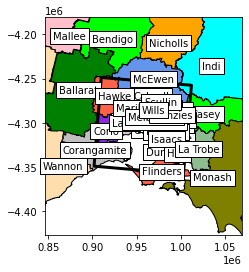

In [19]:
melb_inner_gdf = geopandas.GeoDataFrame(data=[[box(insets['melbourne']['bounds'][0], insets['melbourne']['bounds'][1], insets['melbourne']['bounds'][2], insets['melbourne']['bounds'][3])]], columns=['geometry'], crs=agdf.crs, geometry='geometry')
melb_outer_gdf = geopandas.GeoDataFrame(data=[[box(insets['melbourne']['outer_bounds'][0], insets['melbourne']['outer_bounds'][1], insets['melbourne']['outer_bounds'][2], insets['melbourne']['outer_bounds'][3])]], columns=['geometry'], crs=agdf.crs, geometry='geometry')

# ## Melbourne
show_districts = []
# show_districts += ['Brisbane', 'Griffith', 'Lilley', 'Moreton', 'Oxley', 'Petrie', 'Rankin']
# show_districts += ['Blair', 'Bonner', 'Bowman', 'Dickson', 'Fadden', 'Fairfax', 'Fisher','Forde', 'Longman', 'McPherson', 'Moncrieff', 'Richmond', 'Ryan','Wright']
# show_districts += ['Groom', 'Richmond', 'Page']

the_line_width = 1

label_districts = True
the_annotation_size = 10



show_districts = sorted(show_districts)
# # main_map_partial_districts = {}

if (len(show_districts) > 0):
    show_districts_ix = pandas.Index(show_districts)
#     for x in show_districts:
#         if (x not in main_map_districts):
#             show_districts_ix = show_districts_ix.drop(x)
else:
    show_districts_ix = agdf.index


fig, ax = plt.subplots(1,1)#,figsize=(figsize_base, figsize_base/aspect_ratio))



print('Plotting main map...')
cnt = 0
nrows = len(agdf) # len(geopandas.overlay(agdf.reset_index().to_crs(epsg=the_crs_epsg), im_gdf.to_crs(epsg=the_crs_epsg), how='intersection').set_index('Elect_div'))
for ix, thisrow in agdf.iterrows(): #geopandas.overlay(agdf.reset_index(), im_gdf, how='intersection').set_index('Elect_div').to_crs(epsg=the_crs_epsg).iterrows():#agdf[agdf.index.isin(show_districts_ix)].iterrows():
    if (np.mod(cnt,10) == 0):
        print('\tPlotting District {0:,.0f} of {1:,.0f}...'.format(cnt, nrows))
    agdf[agdf.index == ix].to_crs(epsg=the_crs_epsg).plot(ax=ax, color=district_color_cycle[thisrow['wheel']], edgecolor='black', lw=the_line_width)
    #print(ix)
    if (label_districts):
        if (thisrow.geometry.intersects(unary_union(melb_outer_gdf.geometry.tolist()))):
            annotator = ix
            labelpoint = geopandas.overlay(agdf[agdf.index == ix], melb_outer_gdf, how='intersection').to_crs(epsg=the_crs_epsg).geometry.apply(lambda x: x.centroid).values[0].coords[0]
            ax.annotate(annotator, labelpoint, ha='center', va='center', 
                    bbox=dict(boxstyle='square,pad=0.3', fc='white', ec='black'),
                    fontsize=the_annotation_size)
    cnt += 1
melb_inner_gdf.to_crs(epsg=the_crs_epsg).plot(ax=ax, color='none', edgecolor='black', lw=3)
        
xlimits = [melb_outer_gdf.to_crs(epsg=the_crs_epsg).bounds['minx'].values[0], melb_outer_gdf.to_crs(epsg=the_crs_epsg).bounds['maxx'].values[0]]
ylimits = [melb_outer_gdf.to_crs(epsg=the_crs_epsg).bounds['miny'].values[0], melb_outer_gdf.to_crs(epsg=the_crs_epsg).bounds['maxy'].values[0]]

ax.set_xlim(xlimits)
ax.set_ylim(ylimits)

plt.show()


In [18]:
#geopandas.overlay(agdf.reset_index().to_crs(epsg=the_crs_epsg), im_gdf.to_crs(epsg=the_crs_epsg), how='intersection').set_index('Elect_div').sort_index().index.tolist()

#im_gdf.to_crs(epsg=the_crs_epsg)


846388.3053873149